# Tutorial on MCMC

In [1]:
# normal imports
import numpy as np
import matplotlib.pyplot as plt

# emcee related imports
import emcee
import corner

# modules that I wrote
import sys
sys.path.insert(0,"..") # this is so it can find pendulum_sbi
from pendulum_sbi.pendulum import pendulum

Set this to True if you want to run the MCMC, set it to False if you want to load an MCMC you already ran

In [2]:
run = True
# This is where the saved MCMC will live:
filename = "../pendulum_sbi/MCMC_chains/chain_normal_prior.h5"

## Demonstrate how the pendulum class works and what its attributes are

In [3]:
theta_o = np.array([10, 5, np.pi/4])
time =  np.linspace(0, 10, 100)
noise = [0.1, 0.0, 0.0]

# pendulum object
swing = pendulum(theta_o, time, noise)
print(f'x positions of pendulum with initial parameters theta = {theta_o}', '\n', swing.simulate_x()[0])


x positions of pendulum with initial parameters theta = [10.          5.          0.78539816] 
 [ 3.53553391e+00  3.50690576e+00  3.42069388e+00  3.27401326e+00
  3.06573914e+00  2.79549619e+00  2.46483350e+00  2.04291211e+00
  1.58622116e+00  1.07722304e+00  5.45231856e-01  2.10168145e-03
 -4.84771272e-01 -1.13525367e+00 -1.59546751e+00 -2.05124381e+00
 -2.47045315e+00 -2.81718476e+00 -3.03215100e+00 -3.28414086e+00
 -3.41005180e+00 -3.50154161e+00 -3.53494550e+00 -3.50294218e+00
 -3.41301277e+00 -3.22356153e+00 -3.08896707e+00 -2.68890020e+00
 -2.41596299e+00 -2.06914777e+00 -1.55187783e+00 -1.05202326e+00
 -5.69937483e-01  5.49785549e-03  5.40145340e-01  9.59695846e-01
  1.48835260e+00  2.02620419e+00  2.41222696e+00  2.82123880e+00
  3.09221278e+00  3.22876262e+00  3.36153781e+00  3.51042844e+00
  3.53409198e+00  3.50637748e+00  3.46113725e+00  3.33638284e+00
  3.04138315e+00  2.86395718e+00  2.43112351e+00  2.12365064e+00
  1.66676547e+00  9.28032082e-01  5.85000134e-01  1.5265299

Now, plot several realizations of the pendulum object:

offset g value is 5.0
offset g value is 7.5
offset g value is 10.0
offset g value is 12.5
offset g value is 15.0


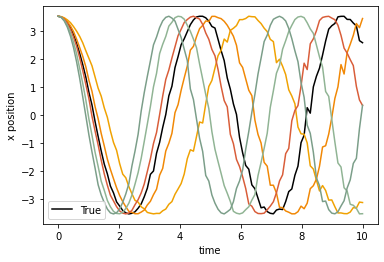

In [4]:
theta_o = np.array([9, 5, np.pi/4])
true_position = pendulum(theta_o, time, noise).simulate_x()

plt.clf()
plt.plot(time, true_position.flatten(), color = 'black', label = 'True')

color_list = ['#F0A202','#F18805','#D95D39','#90B494','#7B9E89']
for i, offset_gs in enumerate(np.linspace(5,15,5)):
    print(f'offset g value is {offset_gs}')
    theta = np.array([offset_gs, 5, np.pi/4])
    
    offset_position = pendulum(theta, time, noise).simulate_x()
    plt.plot(time, offset_position.flatten(), color = color_list[i])
    #plt.annotate(f'log L = {round(log_likelihood(theta, time, true_position, yerr = 1),2)}, g = {round(offset_gs, 2)}', 
    #    xy = (0.02, 0.3 - 0.05*i), xycoords = 'axes fraction', color = color_list[i])
plt.xlabel('time')
plt.ylabel('x position')
plt.legend()
plt.show()

The next step is to carry out the inference. To do so, define the log likelihood, prior, and the log probability (or posterior):

In [5]:
# uniform prior in theta
def log_prior_uniform(theta):
    g, L, theta_o = theta

    if 5.0 < g < 15.0 and 0.0 < L < 10.0 and 0 < theta_o < np.pi/2:
        return 0.0    
    return -np.inf

# normally distributed prior in theta
def log_prior_normal(theta):
    g, L, theta_0 = theta
    # right off the bat, disallow negative numbers:
    if g < 0.0 or L < 0.0 or theta_0 < 0.0 or theta_0 > np.pi/2:
        prior = -np.inf
        #print('prior disallowed', prior)
        return prior
    mu_g, sigma_g = 10, 2
    mu_L, sigma_L = 5, 2
    mu_theta_0, sigma_theta_0 = 0.75, 0.2
    prior = np.log(1.0/(np.sqrt(2*np.pi)*sigma_g))-0.5*(g-mu_g)**2/sigma_g**2 + np.log(1.0/(np.sqrt(2*np.pi)*sigma_L))-0.5*(L - mu_L)**2/sigma_L**2 + np.log(1.0/(np.sqrt(2*np.pi)*sigma_theta_0))-0.5*(theta_0 - mu_theta_0)**2/sigma_theta_0**2
    return prior

# Now set up the likelihood, which will rely on the simulator
def log_likelihood(theta, t, noise, y, yerr):
    model = pendulum(theta, t, noise).simulate_x()
    sigma2 = yerr**2 
    return -0.5 * np.sum((y - model) ** 2 / 2 * sigma2) #+ np.log(sigma2))

def log_probability(theta, t, noise, y, yerr):
    
    lp = log_prior_normal(theta)
    if not np.isfinite(lp):
        return -np.inf

    p_density =  lp + log_likelihood(theta, t, noise, y, yerr)
    '''
    if p_density < -15:
        print('input values', theta)
        print('posterior density', p_density)
        print('prior', lp)
        print('log likelihood', log_likelihood(theta, t, noise, y, yerr))
    '''
    return p_density

Now you can make the same plot as above but now you can calculate the likelihood of all of the different pendulum draws:

offset g value is 5.0
offset g value is 7.5
offset g value is 10.0
offset g value is 12.5
offset g value is 15.0


<Figure size 432x288 with 0 Axes>

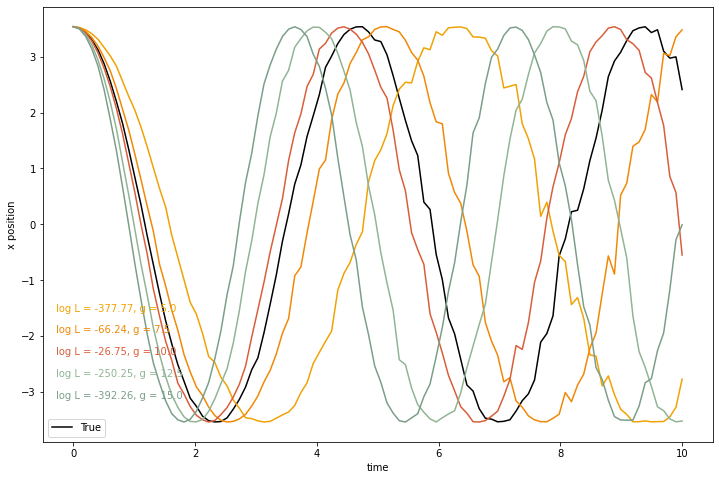

In [6]:
theta_o = np.array([9, 5, np.pi/4])
true_position = pendulum(theta_o, time, noise).simulate_x()

plt.clf()
fig = plt.figure(figsize = (12,8))
plt.plot(time, true_position.flatten(), color = 'black', label = 'True')

color_list = ['#F0A202','#F18805','#D95D39','#90B494','#7B9E89']
for i, offset_gs in enumerate(np.linspace(5,15,5)):
    print(f'offset g value is {offset_gs}')
    theta = np.array([offset_gs, 5, np.pi/4])
    
    offset_position = pendulum(theta, time, noise).simulate_x()
    plt.plot(time, offset_position.flatten(), color = color_list[i])
    plt.annotate(f'log L = {round(log_likelihood(theta, time, noise, true_position, yerr = 1),2)}, g = {round(offset_gs, 2)}', 
        xy = (0.02, 0.3 - 0.05*i), xycoords = 'axes fraction', color = color_list[i])
plt.xlabel('time')
plt.ylabel('x position')
plt.legend()
plt.show()

Notice that the g value that minimizes the log likelihood is the closest to the true pendulum.

Experiment with the shape of the prior:

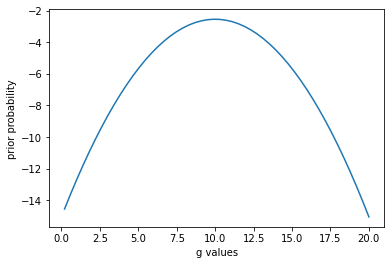

In [7]:
# sample from a bunch of gs
gs = np.linspace(-20,20,100)

prior = [log_prior_normal(np.array([x, 5, np.pi/4])) for x in gs]
plt.plot(gs, prior)
plt.xlabel('g values')
plt.ylabel('prior probability')
plt.show()

In [8]:
# THIS CELL IS BROKEN CURRENTLY

# in two dimensions
# Now do this in 2D
Ls = np.linspace(0,10,100)
x_grid, y_grid = np.meshgrid(gs, Ls)

prior = np.zeros((len(gs),len(Ls)))

prior = []

for x, y in zip(x_grid,y_grid):
    print(len(x), y)
    
    prior.append(log_prior_normal(np.array([x, y, np.pi/4])))
print('shape of prior', np.shape(prior))

prior = [log_prior_normal(np.array([x, y, np.pi/4])) for x,y in zip(x_grid, y_grid)]
#plt.scatter(gs,Ls, c = prior)
plt.contourf(gs, Ls, prior)
plt.colorbar()
plt.axis('scaled')
plt.show()

100 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


<ipython-input-8-017afdb0121d>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  prior.append(log_prior_normal(np.array([x, y, np.pi/4])))


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Time to start the sampling 

The goal is to find the best fit values of parameters given your data p($\Theta$|x), which is the posterior. We do this by sampling using emcee.

The first step is to define the data that you want to find the best fit parameters for. Of course, we already know what the parameters are because we use them to generate the date:

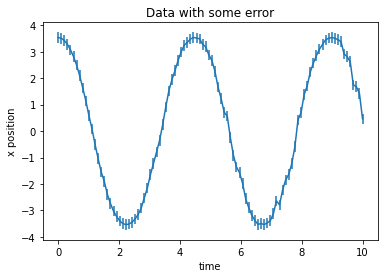

In [9]:
# Generate some synthetic data that you know the solution to 

t =  np.linspace(0, 10, 100)
true = np.array([9.8, 5, np.pi/4])
y = pendulum(true, t, noise).simulate_x()

# Error
yerr = 0.2 * np.ones(np.shape(y))

plt.clf()
plt.errorbar(t, y.flatten(), yerr = yerr)
plt.title('Data with some error')
plt.xlabel('time')
plt.ylabel('x position')
plt.show()

To begin the sampling, we start the 'walkers' or samplers in a gaussian ball centered around the start value:

# walkers = 100


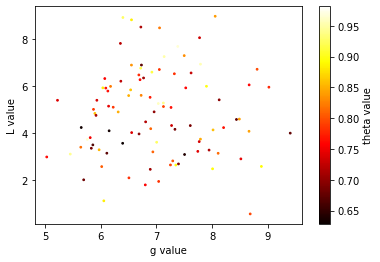

In [10]:
start = np.array([7, 5, np.pi/4])


pos = start + np.array([1e0,2e0,1e-1]) * np.random.randn(100, 3)

nwalkers, ndim = pos.shape
print(f'# walkers = {nwalkers}')

plt.clf()
plt.scatter(pos[:,0], pos[:,1], c = pos[:,2], s = 3, cmap = 'hot')
plt.xlabel('g value')
plt.ylabel('L value')
plt.colorbar(label = 'theta value')
plt.show()


Time to run the inference chains:

In [11]:
if run:
    # Optionally save chain
    # Set up the backend
    # Don't forget to clear it in case the file already exists
    
    backend = emcee.backends.HDFBackend(filename)
    backend.reset(nwalkers, ndim)


    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(t, noise, y, yerr), backend = backend
    )
    # run it
    sampler.run_mcmc(pos, 1000, progress=True);
else:
    sampler = emcee.backends.HDFBackend(filename)

  1%|          | 7/1000 [00:00<00:14, 66.93it/s]/Users/rnevin/Documents/pendulum-sbi/notebooks/../pendulum_sbi/pendulum.py:54: RuntimeWarning: invalid value encountered in sqrt
  theta_t = np.array([theta_os[i] * math.cos(np.sqrt(gs[i] / Ls[i]) * t[i]) for i, _ in enumerate(t)])
100%|██████████| 1000/1000 [00:13<00:00, 76.82it/s]


Grab these inference chains and sample from them to get the posterior distribution:

<Figure size 432x288 with 0 Axes>

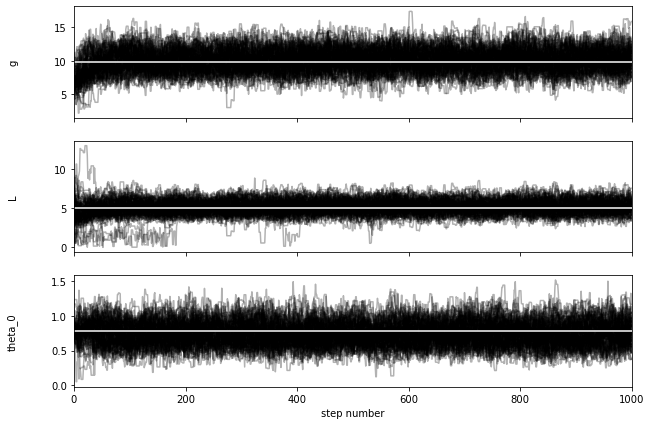

In [14]:
# get the chains, look at them visually
plt.clf()
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["g", "L", "theta_0"]

counter = 0
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axhline(y = true[counter], color = 'white')
    counter += 1

axes[-1].set_xlabel("step number")
plt.show()



(6000, 3)


<Figure size 432x288 with 0 Axes>

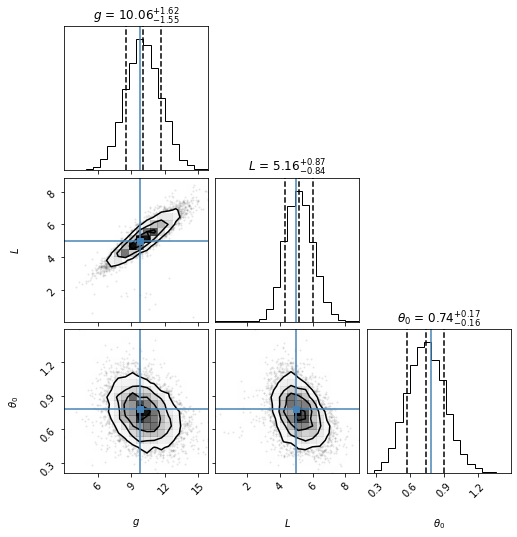

In [15]:
# Then find the marginalized distributions and the 16 and 84th percentile give you the 
# uncertainty on the posterior estimation for each parameter:

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)



plt.clf()
fig = corner.corner(
    flat_samples, truths=[9.8, 5, np.pi/4],
    labels=[
        r"$g$",
        r"$L$",
        r"$\theta_0$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)
plt.show()


In [ ]:


# Get the details of the sampling:
tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))